# Normalize by Internal Standard Quantification

Lexi Jones-Kellett

Date created: 11/16/22
    
Last edited: 09/20/24


Testing code to calculate the absolute abundance of an ASV based on internal standard reads. Code was applied to the whole dataset with "calc_ASV_abundance_from_IS_v2.py". Methods are described in "ASV_abundance_methodology.png".

In [1]:
import csv,math,json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import datetime

In [2]:
# config file contains local directory paths
with open("conf.json") as json_conf : 
    config = json.load(json_conf)

In [3]:
# Plot params
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

### Get the ASV reads for the internal standards (IS)

BP: d__Bacteria; p__Firmicutes; c__Clostridia; o__Lachnospirales; f__Lachnospiraceae; g__Blautia; s__Blautia_producta 

    NOTE: There are 3 'Blautia' ASVs in the dataset, there may be 5 ASVs based on the literature

DR: d__Bacteria; p__Deinococcota; c__Deinococci; o__Deinococcales; f__Deinococcaceae; g__Deinococcus; s__Deinococcus_radiodurans


TT: d__Bacteria; p__Deinococcota; c__Deinococci; o__Thermales; f__Thermaceae; g__Thermus; s__Thermus_thermophilus'
    
    NOTE: There are 2 'Thermus_thermophilus' ASVs in the data

In [4]:
BP_ASV1,BP_ASV2,BP_ASV3 = '0a1e7e4b25a59be69931c5d7f92751f5','f40b1be49d3bca5b8fabdd944abb31bf','2029a1010d7bebac2d09361c275f9fda'
DR_ASV = '6a5fcf5f0ca1f18bca2297194442a6d7'
TT_ASV1,TT_ASV2 = '9aa3ebacc998945a0cd514ca909e5231','5b0d64b13238ee1991c15a9913bec9bc'

Use corrected 16S + 18S merged table to get the reads

In [5]:
ASV_count_file = '221118-1309_LexiGradients-HighCov_2.09-fold-18S-correction_normalized_sequence_counts.tsv'

BP_data,DR_data,TT_data = [],[],[]
with open(config["ASV_count_dir"] + ASV_count_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter='\t')
    c = 0
    for row in csv_reader:
        if c == 0:
            header = row[1:-1]
            print(header)
        else:
            ASV = row[0]
            if (ASV == BP_ASV1) or (ASV == BP_ASV2) or (ASV == BP_ASV3):
                BP_data.append([float(r) for r in row[1:-1]]) # exclude OTU and taxonomy  
            elif (ASV == DR_ASV):
                DR_data.append([float(r) for r in row[1:-1]])
            elif (ASV == TT_ASV1) or (ASV == TT_ASV2):
                TT_data.append([float(r) for r in row[1:-1]])
        c +=1 
        
print(len(BP_data))
print(len(DR_data))
print(len(TT_data))

['10A', '10B', '10C', '11A', '11B', '11C', '12A', '13A', '13B', '13C', '14A', '14B', '14C', '15B', '15C', '16A', '16B', '16C', '16s-even-1', '16S-even-2', '16S-even-3', '16s-mock-even-insilico-v2', '16s-mock-staggered-insilico-v2', '16s-stag-1', '16S-stag-2', '17A', '17B', '17C', '18A', '18B', '18C', '18s-even-1', '18S-even-2', '18s-mock-even-insilico', '18s-mock-staggered-insilico', '18S-stag-1', '18S-stag-2', '19A', '19B', '19C', '20Ai', '20Aii', '20B', '20C', '21A', '21B', '21C', '22A', '22B', '22C', '23A', '23B', '23C', '24A', '24B', '24C', '25A', '25B', '25C', '26A', '26B', '26C', '27A', '27B', '27C', '28A', '28B', '28C', '29A', '29B', '29C', '30A', '30B', '30C', '31A', '31B', '31C', '32A', '32B', '32C', '33A', '33B', '33C', '34A', '34B', '34C', '35A', '35B', '35C', '36A', '36B', '36C', '36Cv2', '37A', '37B', '38A', '38C', '38Cv2', '39A', '39B', '39C', '39Cv2', '3A', '3B', '3C', '40A', '40B', '40C', '41A', '41B', '41C', '41Cv2', '44A', '44B', '44C', '44Cv2', '44RA', '44RB', '44RC'

Sum the counts for the IS with multiple OTUs

In [6]:
BP_count = np.sum(BP_data,axis=0)
DR_count = np.array(DR_data)[0]
TT_count = np.sum(TT_data,axis=0)

print(np.shape(BP_count))
print(np.shape(DR_count))
print(np.shape(TT_count))

(244,)
(244,)
(244,)


### QC: Check counts in control samples

Would expect these to be close to 0

In [7]:
np.array(header)[np.where([i==0 for i in BP_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16S-even-3',
       '16s-mock-even-insilico-v2', '16s-mock-staggered-insilico-v2',
       '16S-stag-2', '18s-even-1', '18S-even-2', '18s-mock-even-insilico',
       '18s-mock-staggered-insilico', '18S-stag-2', 'MQ12', 'PCR-blank-1',
       'PCR-blank-10', 'PCR-blank-2', 'PCR-blank-3', 'PCR-blank-4',
       'PCR-blank-5', 'PCR-blank-6', 'PCR-blank-7', 'PCR-blank-8'],
      dtype='<U30')

In [8]:
#These were expected to be =0
print(BP_count[np.where([i=='PCR-blank-9' for i in np.array(header)])])
print(BP_count[np.where([i=='16s-stag-1' for i in np.array(header)])])
print(BP_count[np.where([i=='18S-stag-1' for i in np.array(header)])])
print(BP_count[np.where([i=='Blank' for i in np.array(header)])])
print(BP_count[np.where([i=='LB' for i in np.array(header)])])

[14.15730337]
[5.31095567]
[6.56842105]
[465.13076298]
[9.74722162]


In [9]:
np.array(header)[np.where([i==0 for i in DR_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16s-mock-even-insilico-v2',
       '16s-mock-staggered-insilico-v2', '16s-stag-1', '16S-stag-2',
       '18S-even-2', '18s-mock-even-insilico',
       '18s-mock-staggered-insilico', '18S-stag-1', 'LB', 'PCR-blank-1',
       'PCR-blank-10', 'PCR-blank-2', 'PCR-blank-4', 'PCR-blank-5',
       'PCR-blank-6', 'PCR-blank-7', 'PCR-blank-8', 'PCR-blank-9'],
      dtype='<U30')

In [10]:
print(DR_count[np.where([i=='16S-even-3' for i in np.array(header)])])
print(DR_count[np.where([i=='18s-even-1' for i in np.array(header)])])
print(DR_count[np.where([i=='18S-stag-2' for i in np.array(header)])])
print(DR_count[np.where([i=='PCR-blank-3' for i in np.array(header)])])
print(DR_count[np.where([i=='MQ12' for i in np.array(header)])])
print(DR_count[np.where([i=='Blank' for i in np.array(header)])])

[2.11942222]
[7.23287671]
[6.16304348]
[5.28426396]
[3.28337808]
[274.89997812]


In [11]:
np.array(header)[np.where([i==0 for i in TT_count])[0]]

array(['12A', '16s-even-1', '16S-even-2', '16s-mock-even-insilico-v2',
       '16s-mock-staggered-insilico-v2', '16S-stag-2', '18S-even-2',
       '18s-mock-even-insilico', '18s-mock-staggered-insilico',
       '18S-stag-1', '18S-stag-2', 'PCR-blank-10', 'PCR-blank-2',
       'PCR-blank-4', 'PCR-blank-5', 'PCR-blank-6', 'PCR-blank-7',
       'PCR-blank-8', 'PCR-blank-9'], dtype='<U30')

In [12]:
print(TT_count[np.where([i=='16s-stag-1' for i in np.array(header)])])
print(TT_count[np.where([i=='18s-even-1' for i in np.array(header)])])
print(TT_count[np.where([i=='PCR-blank-1' for i in np.array(header)])])
print(TT_count[np.where([i=='PCR-blank-3' for i in np.array(header)])])
print(TT_count[np.where([i=='MQ12' for i in np.array(header)])])
print(TT_count[np.where([i=='Blank' for i in np.array(header)])])
print(TT_count[np.where([i=='LB' for i in np.array(header)])])

[4.24876454]
[10.84931507]
[3.32467532]
[7.04568528]
[7.66121552]
[471.72836245]
[43.32098496]


Note: The 'Blank' samples had highest reads

### Internal standards conversion

"absolute" abundance of ASV = (reads of ASV * total # of 16S rRNA spiked from IS) / (reads of IS * vol of filtered seawater)

In [13]:
BP_genome_len,DR_genome_len,TT_genome_len = 6244976,3279485,2143708 #[bp]
BP_rrn,DR_rrn,TT_rrn = 5,3,2 #[16S rRNA copy#/cell]

In [14]:
def calc_IS_Cs(genome_len,rrn,conc):
    """
    Inputs
        genome_len: genome length [bp]
        rrn: copy number of 16S rRNA per cell
        conc: concentration of DNA from quantification, batch specific [ng/muL]
    Output
        CS:
    """
    AgC = 6.022*(10**23) #Avogadro's constant [copies/mol]
    bp_weight = 650 #[g/(mol*bp)]
    CF = 10**9 #[ng/g]
    vol_IS = 20 #[muL]
    
    return (conc*vol_IS*AgC*rrn)/(genome_len*CF*bp_weight)

The DNA concentation (conc in `calc_IS_Cs()`) will depend on which batch the sample was a part of.

In [15]:
# Open table made in script "internal_standards_quant.ipynb"
IS_quants = {}
with open(config["data_dir"] + 'IS_quants.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        else:
            IS_quants[int(row[0])] = [float(j) for j in row[1:]]
        i += 1
IS_quants

['batch', 'bp(ng/muL)', 'dr(ng/muL)', 'tt(ng/muL)']


{1: [0.169154522, 0.157473115, 0.2390493515],
 2: [0.1705743615, 0.150502993, 0.2507307585],
 3: [0.171994201, 0.1315933115, 0.2362742105],
 4: [0.1785125555, 0.144500944, 0.239242966],
 5: [0.188967738, 0.132496846, 0.218590754],
 6: [0.1760601055, 0.138305281, 0.21955882599999998],
 7: [0.172187816, 0.15250367650000002, 0.2435670225],
 8: [0.170832514, 0.12797917450000001, 0.2260771805],
 9: [0.171994201, 0.1273337935, 0.24453509499999998],
 10: [0.1629588585, 0.14850231, 0.220075132],
 11: [0.159990103, 0.148695925, 0.2152347695],
 12: [0.1620553245, 0.129463553, 0.20258529]}

### Calculate Cs for each batch and IS

In [16]:
#format: [BP,DR,TT]
Cs = {}
for key in IS_quants:
    BP_conc,DR_conc,TT_conc = IS_quants[key][0],IS_quants[key][1],IS_quants[key][2]
    Cs[key] = [calc_IS_Cs(BP_genome_len,BP_rrn,BP_conc),calc_IS_Cs(DR_genome_len,DR_rrn,DR_conc),calc_IS_Cs(TT_genome_len,TT_rrn,TT_conc)]
Cs

{1: [2509459.743157478, 2669189.5414535655, 4132466.361256721],
 2: [2530523.5020500408, 2551045.077587112, 4334403.8322297335],
 3: [2551587.2609426053, 2230523.5454384782, 4084492.264032515],
 4: [2648289.069537349, 2449309.5755105074, 4135813.3914966313],
 5: [2803394.941262815, 2245838.571357299, 3778796.855622271],
 6: [2611906.2139427075, 2344292.2912460105, 3795531.998178282],
 7: [2554459.599455503, 2584956.9200877114, 4210563.72199658],
 8: [2534353.2743711467, 2169263.4587133233, 3908215.3438262474],
 9: [2551587.2609426053, 2158324.167803551, 4227298.873196134],
 10: [2417545.1555273575, 2517133.243561577, 3804457.4236761006],
 11: [2373502.7478728495, 2520415.042699598, 3720781.667678333],
 12: [2404140.94869466, 2194423.865096079, 3502109.0455057668]}

In [17]:
batch_file = config["data_dir"] + 'G4_IS_sample_batches.csv'
bad_samples = ['52C','49C','41C','51C','44C','36C','50C','39C','38C','46C','48C','45R']

sample_batches = {}
with open(batch_file) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for row in csv_reader:
        if (i==0) or (row[1] == 'MQ12') or (row[1] == 'LB') or (row[1] == 'Blank'): # these samples did not have internal standards added
            pass
        elif (row[0] == '2'): # we know there was an error with pipetting TT for this batch
            pass
        elif (row[1] in bad_samples): # samples that were zapped in UV, replaced with v2 samples
            pass
        elif (row[1] == 'B2M2'): # zooplankton sample
            pass
        else:
            sample_batches[row[1]] = int(row[0])
        i += 1

Put original number of reads into a dict

In [18]:
IS_reads = {} # key: [BP,DR,TT]
for i in np.arange(0,len(header)):
    IS_reads[header[i]] = [BP_count[i],DR_count[i],TT_count[i]]

Use batch number to get the IS concentration

In [19]:
IS_abundances = {} # key: [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP,
                    #          0          1         2                         
                    #     A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR,
                    #          3          4         5                        
                    #     A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT]
                    #          6          7         8      

vol_seawater = 1000 #mL
for key in sample_batches:
    BP_Cs,DR_Cs,TT_Cs = Cs[sample_batches[key]] 
    BP_reads,DR_reads,TT_reads = IS_reads[key]
        
    # Abundances of the internal standard ASVs with BP as the IS
    A_BP_IS_BP = (BP_reads*BP_Cs)/(BP_reads*vol_seawater)
    A_DR_IS_BP = (DR_reads*BP_Cs)/(BP_reads*vol_seawater)
    A_TT_IS_BP = (TT_reads*BP_Cs)/(BP_reads*vol_seawater)
        
    # Abundances of the internal standard ASVs with DR as the IS
    A_BP_IS_DR = (BP_reads*DR_Cs)/(DR_reads*vol_seawater)
    A_DR_IS_DR = (DR_reads*DR_Cs)/(DR_reads*vol_seawater)
    A_TT_IS_DR = (TT_reads*DR_Cs)/(DR_reads*vol_seawater)
        
    # Abundances of the internal standard ASVs with TT as the IS
    A_BP_IS_TT = (BP_reads*TT_Cs)/(TT_reads*vol_seawater)
    A_DR_IS_TT = (DR_reads*TT_Cs)/(TT_reads*vol_seawater)
    A_TT_IS_TT = (TT_reads*TT_Cs)/(TT_reads*vol_seawater)
        
    IS_abundances[key] = [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP,
                        A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR,
                        A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT]

In [20]:
def ASV_abundance(ASV_reads,GS):
    """
    Absolute ASV abundance estimation from genomic standards. 
    
   
    ASV_reads: number of ASV reads
    GS: genomic standard to use ('BP', 'DR', or 'TT')
    
    """
    vol_seawater = 1000 #mL
    
    if GS == 'BP':
        Cs = BP_Cs
        GS_reads = BP_reads
    elif GS == 'DR':
        Cs = DR_Cs
        GS_reads = DR_reads
    elif GS == 'TT':
        Cs = TT_Cs
        GS_reads = TT_reads
    
    return (ASV_reads*Cs)/(GS_reads*vol_seawater)

In [21]:
IS_abundances = {} # key: [A_BP_IS_BP,A_DR_IS_BP,A_TT_IS_BP, Abundances with BP as the IS
                    #          0          1         2                         
                    #     A_BP_IS_DR,A_DR_IS_DR,A_TT_IS_DR, Abundances with TT as the IS
                    #          3          4         5                        
                    #     A_BP_IS_TT,A_DR_IS_TT,A_TT_IS_TT] Abundances with TT as the IS
                    #          6          7         8      

for key in sample_batches:
    BP_Cs,DR_Cs,TT_Cs = Cs[sample_batches[key]] 
    BP_reads,DR_reads,TT_reads = IS_reads[key]
        
    IS_abundances[key] = [ASV_abundance(BP_reads,'BP'),ASV_abundance(DR_reads,'BP'),ASV_abundance(TT_reads,'BP'),
                          ASV_abundance(BP_reads,'DR'),ASV_abundance(DR_reads,'DR'),ASV_abundance(TT_reads,'DR'),
                          ASV_abundance(BP_reads,'TT'),ASV_abundance(DR_reads,'TT'),ASV_abundance(TT_reads,'TT')]
    
print(len(IS_abundances))

188


### QC: Check the ASV counts of the internal standards

Looking at absolute count estimated by the different IS

In [22]:
A_DR_IS_BP,A_TT_IS_BP = [],[]
A_BP_IS_DR,A_TT_IS_DR = [],[]
A_BP_IS_TT,A_DR_IS_TT = [],[]

# skipping the values normalized by themselves
for key,values in IS_abundances.items():
    A_DR_IS_BP.append(values[1])
    A_TT_IS_BP.append(values[2])
    A_BP_IS_DR.append(values[3])
    A_TT_IS_DR.append(values[5])
    A_BP_IS_TT.append(values[6])
    A_DR_IS_TT.append(values[7])

In [23]:
print('MINIMUMS')
print(min(A_DR_IS_BP))
print(min(A_TT_IS_BP))
print(min(A_BP_IS_DR))
print(min(A_TT_IS_DR))
print(min(A_BP_IS_TT))
print(min(A_DR_IS_TT))
print('MAXIMUMS')
print(max(A_DR_IS_BP))
print(max(A_TT_IS_BP))
print(max(A_BP_IS_DR))
print(max(A_TT_IS_DR))
print(max(A_BP_IS_TT))
print(max(A_DR_IS_TT))
print('MEDIANS')
print(np.median(A_DR_IS_BP))
print(np.median(A_TT_IS_BP))
print(np.median(A_BP_IS_DR))
print(np.median(A_TT_IS_DR))
print(np.median(A_BP_IS_TT))
print(np.median(A_DR_IS_TT))

MINIMUMS
1524.0561164799192
3004.086811251613
2036.00011898301
3508.164464076373
1267.5738504438596
991.1685783700584
MAXIMUMS
3092.32422490271
7813.981291981762
3992.8210076963614
8553.488194800011
2975.4170473202603
2631.498503398251
MEDIANS
2101.692843523657
4394.418828570895
2825.2714464335168
4824.164736601448
2332.5246899849244
1954.8787451433168


In [24]:
# Compare abundances of internal standard ASVs normalized by the other internal standards; ideally should be 1:1
DR_TT_slope,DR_TT_intercept,DR_TT_r_value,DR_TT_p_value,DR_TT_std_err = stats.linregress(A_DR_IS_BP,A_TT_IS_BP)
BP_TT_slope,BP_TT_intercept,BP_TT_r_value,BP_TT_p_value,BP_TT_std_err = stats.linregress(A_BP_IS_DR,A_TT_IS_DR)
BP_DR_slope,BP_DR_intercept,BP_DR_r_value,BP_DR_p_value,BP_DR_std_err = stats.linregress(A_BP_IS_TT,A_DR_IS_TT)

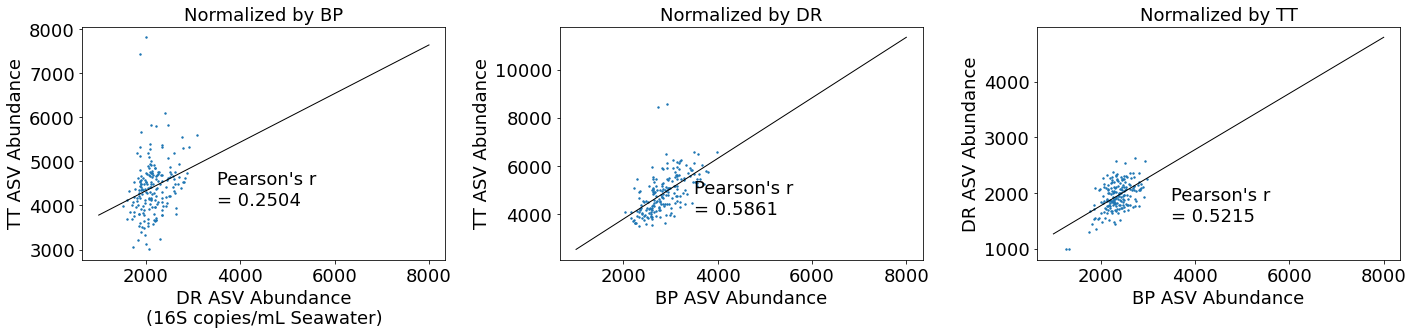

In [25]:
fontsize=18
size = 2
fig,ax = plt.subplots(1,3,figsize=(20,5))

x = np.arange(1000,8000)

ax[0].scatter(A_DR_IS_BP,A_TT_IS_BP,s=size)
ax[0].plot(x,DR_TT_slope*x+DR_TT_intercept,linewidth=1,c='k')
ax[0].text(3500,4000,'Pearson\'s r\n= %s'%(round(DR_TT_r_value,4)))
ax[0].set_title('Normalized by BP')
ax[0].set_xlabel('DR ASV Abundance\n(16S copies/mL Seawater)')
ax[0].set_ylabel('TT ASV Abundance')

ax[1].scatter(A_BP_IS_DR,A_TT_IS_DR,s=size)
ax[1].plot(x,BP_TT_slope*x+BP_TT_intercept,linewidth=1,c='k')
ax[1].text(3500,4000,'Pearson\'s r\n= %s'%(round(BP_TT_r_value,4)))
ax[1].set_title('Normalized by DR')
ax[1].set_xlabel('BP ASV Abundance')
ax[1].set_ylabel('TT ASV Abundance')

ax[2].scatter(A_BP_IS_TT,A_DR_IS_TT,s=size)
ax[2].plot(x,BP_DR_slope*x+BP_DR_intercept,linewidth=1,c='k')
ax[2].text(3500,1500,'Pearson\'s r\n= %s'%(round(BP_DR_r_value,4)))
ax[2].set_title('Normalized by TT')
ax[2].set_xlabel('BP ASV Abundance')
ax[2].set_ylabel('DR ASV Abundance')

plt.tight_layout()
plt.show()

Check which samples are the bad estimates

In [26]:
for key,values in IS_abundances.items():
    if np.any([v > 7000 for v in values]):
        print(key)

7C
19C


In [27]:
for key,values in IS_abundances.items():
    if np.any([v < 1000 for v in values]):
        print(key)

7C


NOTE: Both 7C & 19C are part of batch 8i

### Plot Internal Standard Concentration

In [97]:
metadata

{'10B': ['20211120', '01:20', 30.1215, 238.4522],
 '10C': ['20211120', '01:20', 30.1215, 238.4522],
 '11A': ['20211120', '02:54', 29.9369, 238.1739],
 '11B': ['20211120', '02:54', 29.9369, 238.1739],
 '11C': ['20211120', '02:54', 29.9369, 238.1739],
 '13B': ['20211120', '04:52', 29.6959, 237.7231],
 '13C': ['20211120', '04:52', 29.6959, 237.7231],
 '14A': ['20211120', '06:54', 29.4512, 237.3091],
 '14B': ['20211120', '06:54', 29.4512, 237.3091],
 '14C': ['20211120', '06:54', 29.4512, 237.3091],
 '15B': ['20211120', '08:52', 29.2158, 236.8854],
 '15C': ['20211120', '08:52', 29.2158, 236.8854],
 '16A': ['20211120', '10:54', 29.0, 236.5574],
 '16B': ['20211120', '10:54', 29.0, 236.5574],
 '16C': ['20211120', '10:54', 29.0, 236.5574],
 '17B': ['20211120', '12:44', 28.739, 236.1088],
 '17C': ['20211120', '12:44', 28.739, 236.1088],
 '18B': ['20211120', '14:43', 28.503, 235.714],
 '18C': ['20211120', '14:43', 28.503, 235.714],
 '19B': ['20211121', '02:03', 28.2847, 235.3517],
 '19C': ['20211

In [98]:
xlabels,BP_prop_subset,DR_prop_subset,TT_prop_subset = [],[],[],[]
for key in metadata:
    xlabels.append(key)

    BP_prop_subset.append(BP_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])
    DR_prop_subset.append(DR_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])
    TT_prop_subset.append(TT_count[np.where([i==str(key) for i in np.array(header)])][0]/reads[key][2])

In [99]:
BP_prop_subset = np.array(BP_prop_subset)
DR_prop_subset = np.array(DR_prop_subset)
TT_prop_subset = np.array(TT_prop_subset)

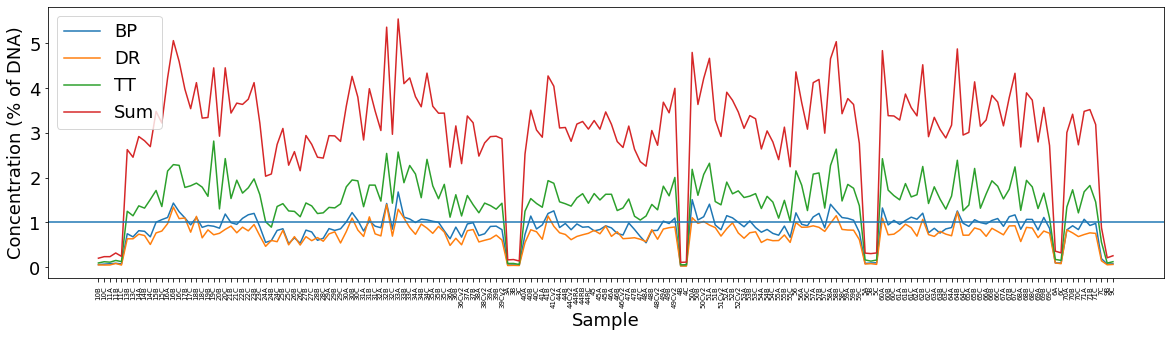

In [100]:
fig,ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(BP_prop_subset,label='BP')
ax.plot(DR_prop_subset,label='DR')
ax.plot(TT_prop_subset,label='TT')

#total_IS = []
#for i in np.arange(0,len(BP_prop_subset)):
#    total_IS.append(BP_prop_subset[i]+DR_prop_subset[i]+TT_prop_subset[i])
    
ax.plot(np.sum((BP_prop_subset,DR_prop_subset,TT_prop_subset),axis=0),label='Sum')
ax.axhline(1)

ax.set_xlabel('Sample',fontsize=fontsize)
ax.set_ylabel('Concentration (% of DNA)',fontsize=fontsize)

ax.set_xticks(np.arange(0,len(BP_prop_subset)))
ax.set_xticklabels(xlabels,fontsize=7,rotation=90)

#ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
plt.show()

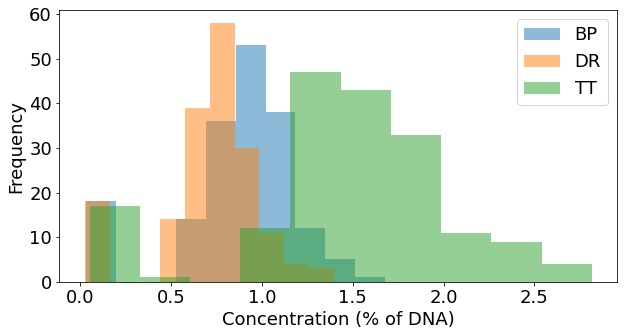

In [101]:
fig,ax = plt.subplots(1,1,figsize=(10,5))

ax.hist(BP_prop_subset,alpha=0.5,bins=10,label='BP')
ax.hist(DR_prop_subset,alpha=0.5,bins=10,label='DR')
ax.hist(TT_prop_subset,alpha=0.5,bins=10,label='TT')

ax.tick_params(axis='both', labelsize=fontsize)
ax.set_ylabel('Frequency',fontsize=fontsize)
ax.set_xlabel('Concentration (% of DNA)',fontsize=fontsize)

ax.legend(fontsize=fontsize)